<a href="https://colab.research.google.com/github/teruyo14/BERT-Related/blob/main/BERT_FT_CoLAipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install transformers
import transformers

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

In [3]:
import os
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-and-Computer-Vision-3rd-Edition/master/Chapter05/in_domain_train.tsv --output "in_domain_train.tsv"
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-and-Computer-Vision-3rd-Edition/master/Chapter05/out_of_domain_dev.tsv --output "out_of_domain_dev.tsv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  428k  100  428k    0     0  1331k      0 --:--:-- --:--:-- --:--:-- 1330k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28506  100 28506    0     0   110k      0 --:--:-- --:--:-- --:--:--  110k


In [4]:
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [5]:
sentences = df.sentence.values
sentences = ["[CLS]" + sentence + "[SEP]" for sentence in sentences]
labels = df.label.values

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
MAX_LEN = 128
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [8]:
attention_masks = []
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [9]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2024, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2024, test_size=0.1)

In [10]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [11]:
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [12]:
from transformers import BertModel, BertConfig
configuration = BertConfig()

model = BertModel(configuration)

configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [13]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model = nn.DataParallel(model)
model.to("cuda")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, 

In [14]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [15]:
epochs = 4
optimizer = AdamW(optimizer_grouped_parameters,lr = 2e-5, eps = 1e-8)
total_steps = len(train_dataloader)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [17]:
t = []
train_loss_set = []

for _ in trange(epochs, desc="Epoch"):
  model.train()

  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to("cuda") for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    optimizer.zero_grad()
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))


  model.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader:
    batch = tuple(t.to("cuda") for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.5171332202264383


Epoch:  25%|██▌       | 1/4 [00:54<02:43, 54.46s/it]

Validation Accuracy: 0.7978395061728395
Train loss: 0.395339864789203


Epoch:  50%|█████     | 2/4 [01:44<01:43, 51.83s/it]

Validation Accuracy: 0.7978395061728395
Train loss: 0.3998607979523196


Epoch:  75%|███████▌  | 3/4 [02:34<00:51, 51.21s/it]

Validation Accuracy: 0.7978395061728395
Train loss: 0.398820758236889


Epoch: 100%|██████████| 4/4 [03:25<00:00, 51.26s/it]

Validation Accuracy: 0.7978395061728395


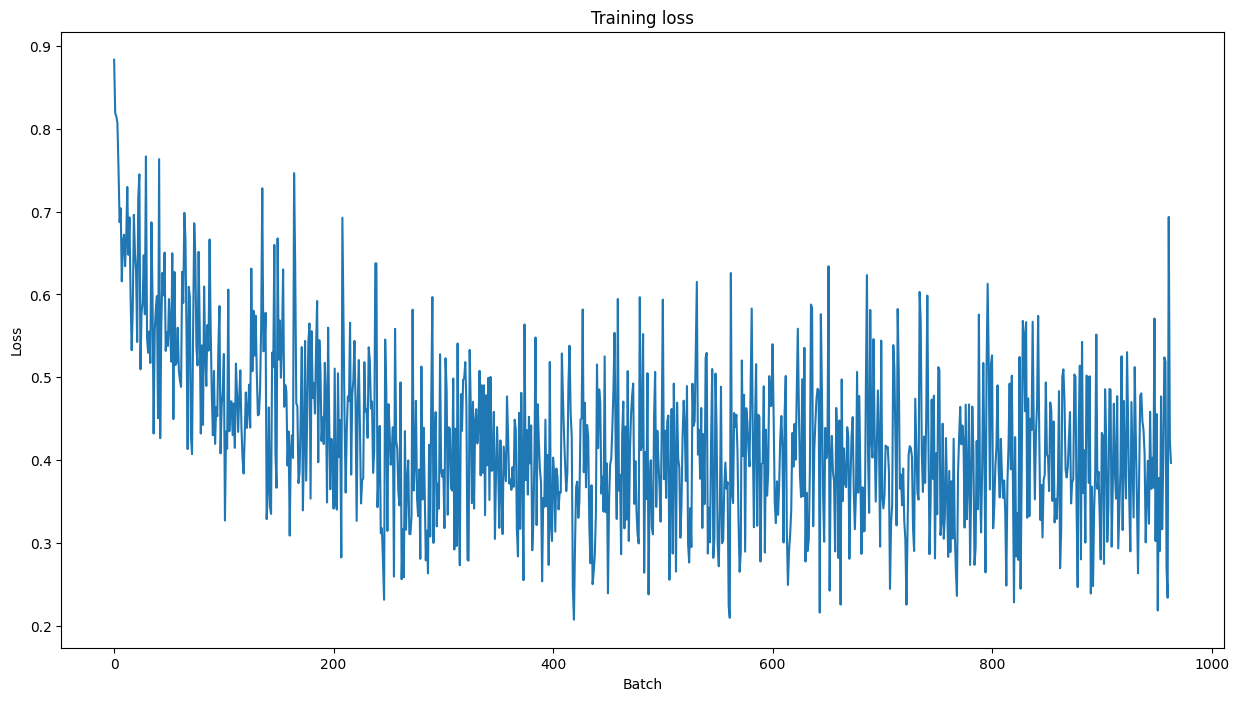

In [18]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [19]:
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [20]:
sentences = df.sentence.values

sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

MAX_LEN = 128

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [21]:
import numpy as np

def softmax(logits):
    e = np.exp(logits)
    return e / np.sum(e)

In [22]:
import torch
import numpy as np

model.eval()

raw_predictions, predicted_classes, true_labels = [], [], []

for batch in prediction_dataloader:
  batch = tuple(t.to("cuda") for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  logits = outputs['logits'].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  b_input_ids = b_input_ids.to('cpu').numpy()
  batch_sentences = [tokenizer.decode(input_ids, skip_special_tokens=True) for input_ids in b_input_ids]

  probabilities = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)

  batch_predictions = np.argmax(probabilities, axis=1)

  for i, sentence in enumerate(batch_sentences):
    print(f"Sentence: {sentence}")
    print(f"Prediction: {logits[i]}")
    print(f"Sofmax probabilities", softmax(logits[i]))
    print(f"Prediction: {batch_predictions[i]}")
    print(f"True label: {label_ids[i]}")

  raw_predictions.append(logits)
  predicted_classes.append(batch_predictions)
  true_labels.append(label_ids)

Sentence: somebody just left - guess who.
Prediction: [-0.68621826  0.93728083]
Sofmax probabilities [0.16472286 0.8352771 ]
Prediction: 1
True label: 1
Sentence: they claimed they had settled on something, but it wasn't clear what they had settled on.
Prediction: [-0.85667425  1.3373427 ]
Sofmax probabilities [0.10028905 0.899711  ]
Prediction: 1
True label: 1
Sentence: if sam was going, sally would know where.
Prediction: [-0.9055284  1.3299289]
Sofmax probabilities [0.09661129 0.90338874]
Prediction: 1
True label: 1
Sentence: they're going to serve the guests something, but it's unclear what.
Prediction: [-0.9401168  1.4324164]
Sofmax probabilities [0.08529128 0.91470873]
Prediction: 1
True label: 1
Sentence: she's reading. i can't imagine what.
Prediction: [-0.5230466  0.5003351]
Sofmax probabilities [0.26436922 0.73563075]
Prediction: 1
True label: 1
Sentence: john said joan saw someone from her graduating class.
Prediction: [-1.0705309  1.5918627]
Sofmax probabilities [0.06522923

In [23]:
from sklearn.metrics import matthews_corrcoef

true_labels_flattened = [label for batch in true_labels for label in batch]
predicted_classes_flattened = [pred for batch in predicted_classes for pred in batch]

mcc = matthews_corrcoef(true_labels_flattened, predicted_classes_flattened)

print(f"MCC: {mcc}")

MCC: 0.529280670679667


In [24]:
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.0 MB/s eta 0:00:00


In [25]:
import ipywidgets as widgets
from IPython.display import display

def model_predict_interface(sentence):
    prediction = predict(sentence, model, tokenizer)
    if prediction == 0:
        return "Grammatically Incorrect"
    elif prediction == 1:
        return "Grammatically Correct"
    else:
        return f"Label: {prediction}"

text_input = widgets.Textarea(
    placeholder='Type something',
    description='Sentence:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='50px')
)

output_label = widgets.Label(
    value='',
    layout=widgets.Layout(width='100%', height='25px'),
    style={'description_width': 'initial'}
)

def on_text_submit(change):
    output_label.value = model_predict_interface(change.new)

text_input.observe(on_text_submit, names='value')

display(text_input, output_label)


Textarea(value='', description='Sentence:', layout=Layout(height='50px', width='100%'), placeholder='Type some…

Label(value='', layout=Layout(height='25px', width='100%'), style=DescriptionStyle(description_width='initial'…